# Dataprocessing the Pecan dataset using pandas

### Importing libraries

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
plt.style.use('ggplot')
import matplotlib.dates as dates
import warnings
warnings.filterwarnings("ignore")

# plots directory
figure_directory= 'figures/'
# change so that all figures have font size defulat as 22
plt.rcParams.update({'font.size': 18})
# figure size always the same
plt.figure(figsize=(16,12))

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

In [6]:
import os
import sys
import pandas as pd
from collections import defaultdict
import glob

In [12]:
def read_data():
    df = pd.DataFrame()
    houses = []
    path = "datasets/*.csv"
    for fname in glob.glob(path):
        house_df = pd.read_csv(fname)
        houseID = int(fname.split('.')[0].split('/')[1])
        
        house_df['DateTime'] = pd.to_datetime(house_df['DateTime'])
        mask = (house_df['DateTime'] >= '2014-1-1') & (house_df['DateTime'] < '2015-1-1')
        house_df = house_df.loc[mask]
        house_df = house_df.set_index('DateTime')
        house_df = house_df.resample('1H').first()  # resample from 15 mins to 1 hour 
        house_df = house_df.reset_index(drop=False)
        
        if len(house_df) == 8760 and house_df.isnull().sum().sum() <= 100: # one year hours 
            houses.append(houseID)
            house_df.columns = ['localhour', 'use', 'air1', 'furnace1', 'dishwasher1', 'regrigerator1']  
            house_df = house_df.fillna(method='pad') 
            house_df['regrigerator1'] = house_df['regrigerator1'].fillna(method='ffill')
            appliances_sum = house_df[['air1', 'furnace1', 'dishwasher1', 'regrigerator1']].sum(axis=1)
            house_df['other'] = house_df['use'].subtract(appliances_sum)
            house_df['house'] = houseID
            house_df = house_df.set_index('house')
           
            df = pd.concat([df, house_df])
                               
    return df, houses

In [16]:
df, houses = read_data()
print(df.head())

                localhour    use   air1  furnace1  dishwasher1  regrigerator1  \
house                                                                           
2242  2014-01-01 00:00:00  1.194  0.032     0.013          0.0          0.083   
2242  2014-01-01 01:00:00  1.185  0.032     0.271          0.0          0.078   
2242  2014-01-01 02:00:00  1.307  0.032     0.305          0.0          0.087   
2242  2014-01-01 03:00:00  1.515  0.031     0.648          0.0          0.109   
2242  2014-01-01 04:00:00  1.175  0.032     0.408          0.0          0.092   

       other  
house         
2242   1.066  
2242   0.804  
2242   0.883  
2242   0.727  
2242   0.643  


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 2242 to 2845
Data columns (total 7 columns):
localhour        183960 non-null datetime64[ns]
use              183960 non-null float64
air1             183960 non-null float64
furnace1         183960 non-null float64
dishwasher1      183960 non-null float64
regrigerator1    183960 non-null float64
other            183960 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 11.2 MB


In [9]:
df.describe()

,use,air1,furnace1,dishwasher1,regrigerator1,other
count,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000
mean,0.998322,0.251435,0.090556,0.009490,0.087300,0.559541
std,1.300115,0.652966,0.308043,0.075677,0.093179,0.845629
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.055000
25%,0.233000,0.000000,0.005000,0.000000,0.006000,0.141000
50%,0.484000,0.000000,0.012000,0.000000,0.074000,0.283000
75%,1.182000,0.018000,0.056000,0.000000,0.130000,0.562000
max,21.436000,4.411000,10.971000,1.378000,1.486000,12.751000


In [10]:
def format_data(df, houses):
    '''
    Parameters: dataframe of the apppliacnes
    Return: dictionary contains all X^T x m
    '''
    d = {}
    for appliance in df.columns.tolist():
        started = 0
        
        for i in houses:
            if started == 0:
                d[str(appliance)] = df[[str(appliance)]][df[str(appliance)].index == i]
                started = 1
                dfindex = d[str(appliance)].index    
            else:
                d[str(appliance)][str(i)] = pd.Series(df[str(appliance)][df[str(appliance)].index == i].values,index=dfindex)

        d[str(appliance)]=d[str(appliance)].rename(columns = {str(appliance):str(dfindex[0])})
        d[str(appliance)].reset_index(drop=True, inplace=True)
        
    return d
    
dic = format_data(df, houses)
dic['use'].tail(5)

,2242,94,2034,2829,2974,135,2156,508,3273,898,...,3687,3678,3443,3721,3873,2004,3938,2171,2710,2845
8755,6.182,2.251,1.346,2.192,4.790,0.827,6.396,0.522,0.358,0.807,...,0.247,1.579,1.688,5.551,0.476,0.416,0.190,1.188,3.999,1.302
8756,5.136,1.235,1.629,2.470,1.950,0.371,3.245,0.779,3.503,0.360,...,0.697,1.199,0.381,3.926,2.414,0.353,0.450,1.648,3.027,1.134
8757,4.054,1.081,0.532,2.345,1.932,0.596,3.343,1.770,3.265,0.242,...,0.763,1.120,0.381,0.424,0.100,0.453,0.151,0.761,14.056,0.919
8758,2.633,1.115,0.318,2.432,2.267,1.096,1.780,1.029,2.557,0.244,...,0.935,0.979,1.325,0.497,0.209,0.355,0.452,0.872,6.247,0.654
8759,1.836,1.079,0.399,3.066,2.109,0.522,1.414,0.879,0.918,0.336,...,1.889,0.838,0.264,1.259,0.100,0.759,0.474,1.903,6.971,1.051


In [25]:
key = list(dic.keys())
key
# columns = dic[key].columns.tolist()

['localhour',
 'use',
 'air1',
 'furnace1',
 'dishwasher1',
 'regrigerator1',
 'other']

In [26]:
def split2(d,portion,timeduration, start_t):
    '''
    Parameters: d = dictionary, portion 0.5 - 0.9, timeduration 1-8760, start_t 1-8760

    Return: x_train,x_test dictionarys containing dataframes of all the appliances within the timeframe.
    '''
    x_train = {}
    x_test = {}
    
    train_list  = range(int(timeduration * 0.0 + start_t),int(timeduration * portion +start_t))
    print(train_list)
    test_list = range(int(timeduration * portion)+start_t,int(timeduration * 1.0)+start_t)
    print(test_list)
    for key in d.keys():
        x_train[key] = d[key].loc[train_list,:]
        x_test[key] = d[key].loc[test_list,:]

    return x_train,x_test

### Splitting the dataframes into portions of a month

In [27]:
t = 12

x_train,x_test = split2(dic, 0.5, t, 4000)
x_train_use = x_train.pop('use',None)
x_test_use = x_test.pop('use',None)
x_train_localhour = x_train.pop('localhour',None)
x_test_localhour = x_test.pop('localhour',None)

range(4000, 4006)
range(4006, 4012)


In [28]:
x_train[list(x_train.keys())[0]].shape

(6, 21)

In [29]:
x_train.values()

dict_values([       2242     94   2034   2829   2974    135   2156    508   3273    898  \
4000  2.279  0.000  0.000  1.508  0.012  0.601  0.695  0.000  0.000  0.000   
4001  1.267  0.000  0.000  1.254  0.008  1.277  2.232  0.000  0.000  1.699   
4002  2.242  0.786  2.447  1.363  2.303  0.766  3.873  0.125  0.000  0.002   
4003  2.187  0.437  2.426  1.007  1.315  0.000  3.819  1.146  0.000  1.644   
4004  2.135  0.215  0.000  0.211  0.159  0.341  1.828  0.299  1.148  0.000   
4005  0.020  0.235  0.000  1.067  1.977  0.000  1.785  0.000  0.000  1.564   

      ...  3687   3678   3443   3721   3873   2004  3938   2171   2710   2845  
4000  ...   0.0  1.225  0.666  2.028  1.517  2.836   0.0  0.940  2.832  1.375  
4001  ...   0.0  1.247  0.617  1.015  1.262  1.331   0.0  3.818  2.787  0.012  
4002  ...   0.0  1.222  0.751  1.598  0.000  1.346   0.0  3.750  2.782  3.371  
4003  ...   0.0  0.000  0.000  0.892  0.000  0.955   0.0  0.004  2.738  3.668  
4004  ...   0.0  1.150  0.000  1.002  0.

## Splitting into weekdays and weekends

In [30]:
week = pd.DatetimeIndex(pd.to_datetime(df['localhour'])).weekday
weekdays = np.in1d(week.ravel(),range(5)).reshape(week.shape)
weekends = week[np.where(week > 4,week,0)]
weekends = np.in1d(week.ravel(),[5,6]).reshape(week.shape)

In [31]:
df[weekdays].describe()

,use,air1,furnace1,dishwasher1,regrigerator1,other
count,131544.000000,131544.000000,131544.000000,131544.000000,131544.000000,131544.000000
mean,1.001570,0.253002,0.095067,0.009279,0.087057,0.557165
std,1.302744,0.651423,0.327262,0.074594,0.093999,0.846851
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.045000
25%,0.231000,0.000000,0.005000,0.000000,0.006000,0.137000
50%,0.488000,0.000000,0.012000,0.000000,0.074000,0.281000
75%,1.192000,0.023000,0.057000,0.000000,0.129000,0.556000
max,21.436000,4.374000,10.971000,1.378000,1.486000,11.138000


In [32]:
df[weekends].to_csv('weekendpecanhour2014')
df[weekdays].to_csv('weekdayspecanhour2014')

In [33]:
df[weekends].describe()

,use,air1,furnace1,dishwasher1,regrigerator1,other
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,0.990170,0.247500,0.079234,0.010020,0.087911,0.565504
std,1.293469,0.656813,0.253122,0.078328,0.091087,0.842535
min,0.008000,0.000000,0.000000,0.000000,0.000000,-0.055000
25%,0.239000,0.000000,0.005000,0.000000,0.006000,0.149000
50%,0.475000,0.000000,0.011000,0.000000,0.076000,0.287000
75%,1.157000,0.017000,0.055000,0.000000,0.131000,0.579000
max,15.525000,4.411000,10.864000,1.334000,1.303000,12.751000


### Data Exploration

In [34]:
local = df['localhour'].tolist()
import datetime, re
xticks = map(lambda x: re.split('\s',x)[0],local)

### Usage for texas is like a poisson distribution, could be used in future research

0.5967250967597508 1.4242749032402493


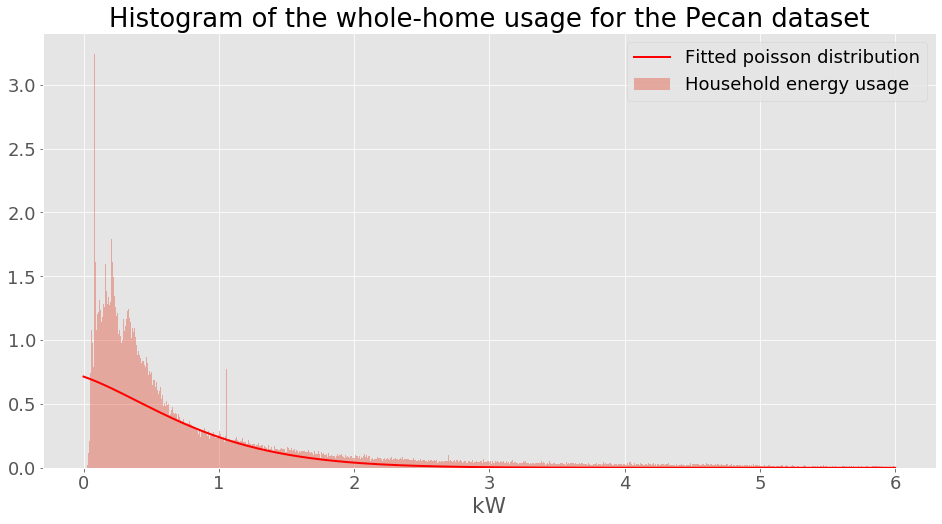

In [37]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats
plt.figure(figsize=(16,8))

#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
#entries, bin_edges, patches = df_plot[df_plot < 6].hist(bins=1000, figsize=(16,12),normed=True)
# get poisson deviated random numbers
data = np.random.poisson(2, 1000)
entries, bin_edges, patches = plt.hist(df_plot,bins=1000,normed=True,label='Household energy usage', alpha=0.4)

# the bins should be of integer width, because poisson is an integer distribution
#entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

(loc, scale) = stats.exponweib.fit_loc_scale(data, 1, 1)
print(loc, scale)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 6, 1000)

# plt.plot(x, weib(x, loc, scale))
# plt.hist(data, data.max(), normed=True)
curve = plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2,label='Fitted poisson distribution')

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

# plt.savefig(figure_directory+'histusage.png')

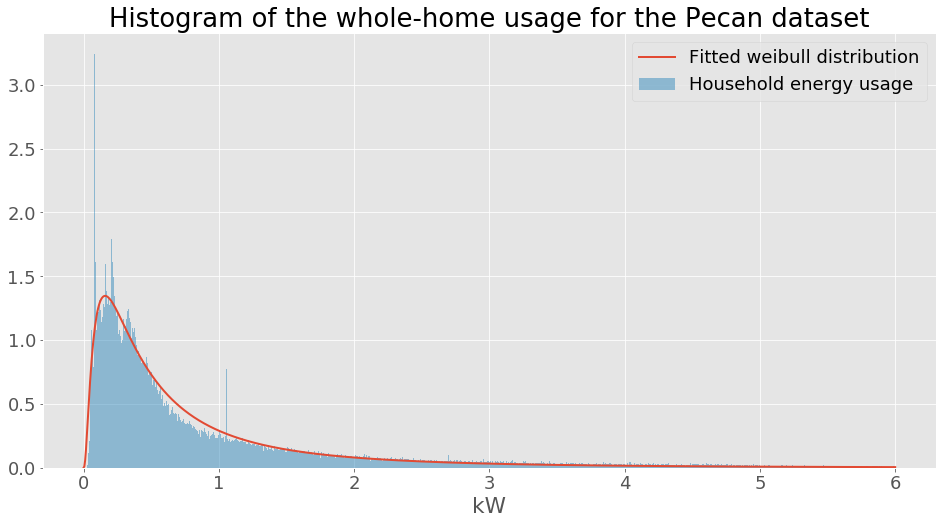

In [38]:
from scipy import stats
plt.figure(figsize=(16,8))
x_plot = np.linspace(0, 6, 1000)
#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
plt.plot(x_plot, stats.exponweib.pdf(x_plot, *stats.exponweib.fit(df_plot, 1, 1, scale=0.2, loc=0)),lw=2,label='Fitted weibull distribution')
_ = plt.hist(df_plot, bins=1000, normed=True, alpha=0.5, label='Household energy usage');

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

# plt.savefig(figure_directory+'new_histusage.png')

Text(0, 0.5, 'kW')

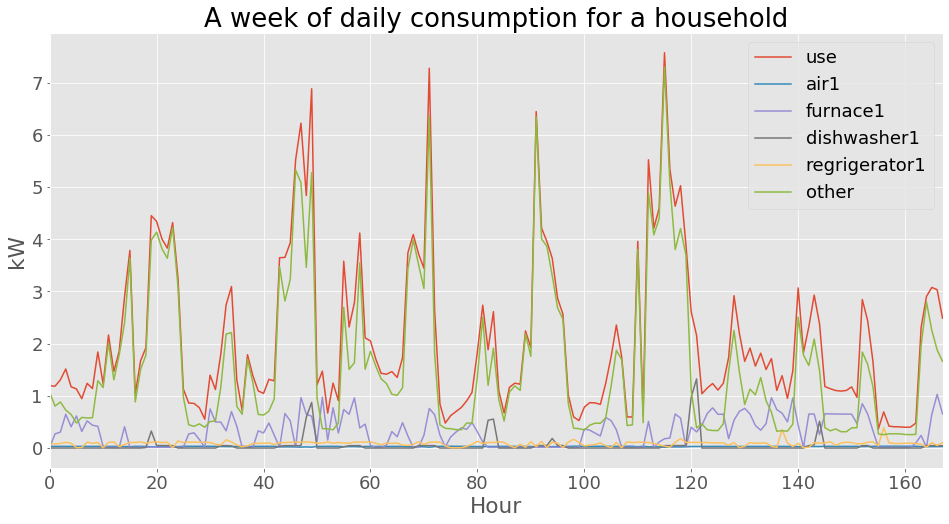

In [39]:
df_test = df.copy()
df_test.drop('localhour', axis=1, inplace=True)
hours = 24*7
df_test[0:hours].reset_index(drop=True).plot(figsize=(16,8))
plt.title('A week of daily consumption for a household')
plt.xlabel('Hour')
plt.ylabel('kW')

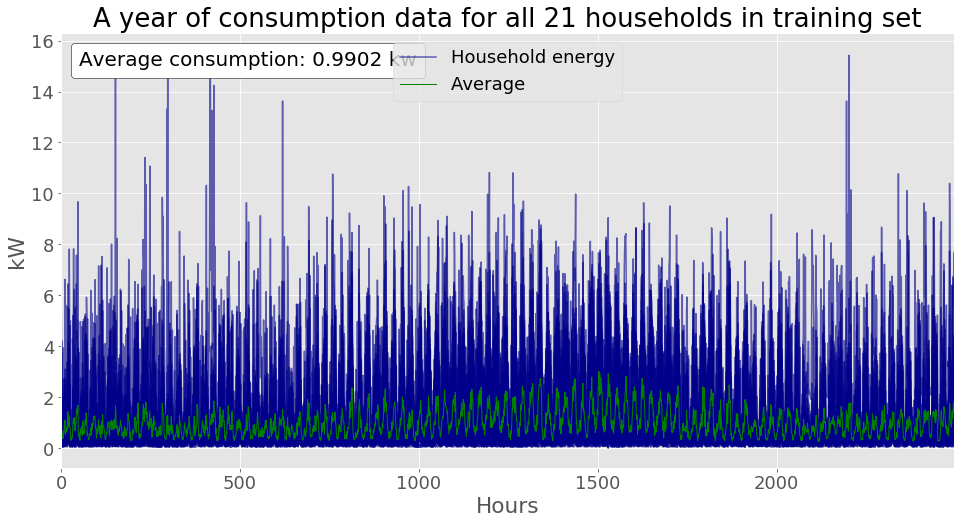

In [58]:
import numpy.ma as ma

df_sort = df.set_index(df['localhour'], drop=True).sort_index()


average_use = list(map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique()))
leng = len(average_use)

mean_use = np.mean(np.where(np.isnan(average_use), ma.array(average_use, mask=np.isnan(average_use)).mean(axis=0), average_use))

fig, ax = plt.subplots(figsize=(16,8))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', alpha=0.6, label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)

s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='green',label='Average Use',lw=1, ax=ax)

plt.title('A year of consumption data for all {} households in training set'.format(len(houses)))
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: {:.4f} kw".format(mean_use),
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )

at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

### plotting the weekend household use of the week dataset

In [66]:
df = pd.read_csv('weekendpecanhour2014')
df = df.set_index(df['house'])
df_sort =df.set_index(df['localhour']).sort_index()
average_use = list(map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique()))
leng = len(average_use)
df.head()

,house,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,,
2242,2242,2014-01-04 00:00:00,2.636,0.029,0.639,0.047,0.113,1.808
2242,2242,2014-01-04 01:00:00,0.839,0.033,0.247,0.000,0.114,0.445
2242,2242,2014-01-04 02:00:00,0.478,0.035,0.024,0.000,0.041,0.378
2242,2242,2014-01-04 03:00:00,0.621,0.034,0.211,0.000,0.006,0.370
2242,2242,2014-01-04 04:00:00,0.699,0.034,0.306,0.000,0.006,0.353


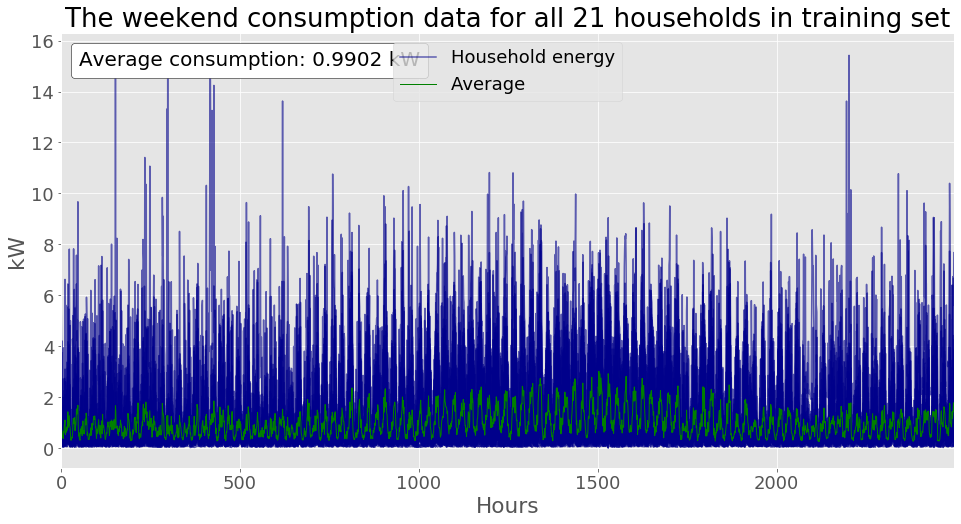

In [60]:
fig, ax = plt.subplots(figsize=(16, 8))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', alpha=0.6, label='Household energy' if i == 0 else '', ax=ax)
    i += 1

mean_use = np.mean(np.where(np.isnan(average_use), ma.array(average_use, mask=np.isnan(average_use)).mean(axis=0), average_use))
    
s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='Green',label='Average Use',lw=1, ax=ax)

plt.title('The weekend consumption data for all {} households in training set'.format(len(houses)))
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: {:.4f} kW".format(mean_use),
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

In [62]:
df = pd.read_csv('weekdayspecanhour2014')
df = df.set_index(df['house'])
df_sort =df.set_index(df['localhour']).sort_index()
average_use = list(map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique()))
leng = len(average_use)
df.head()

,house,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,,
2242,2242,2014-01-01 00:00:00,1.194,0.032,0.013,0.0,0.083,1.066
2242,2242,2014-01-01 01:00:00,1.185,0.032,0.271,0.0,0.078,0.804
2242,2242,2014-01-01 02:00:00,1.307,0.032,0.305,0.0,0.087,0.883
2242,2242,2014-01-01 03:00:00,1.515,0.031,0.648,0.0,0.109,0.727
2242,2242,2014-01-01 04:00:00,1.175,0.032,0.408,0.0,0.092,0.643


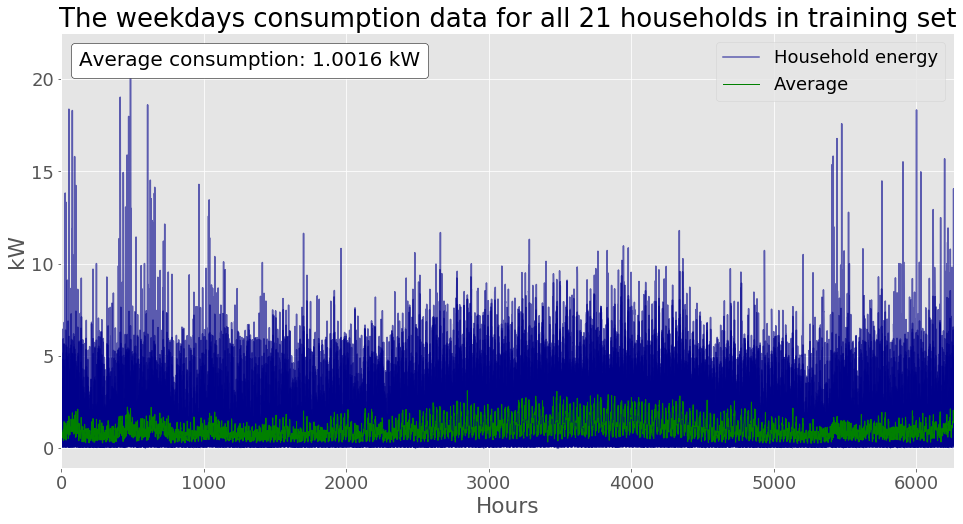

In [64]:
fig, ax = plt.subplots(figsize=(16, 8))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', alpha=0.6, label='Household energy' if i == 0 else '', ax=ax)
    i += 1

mean_use = np.mean(np.where(np.isnan(average_use), ma.array(average_use, mask=np.isnan(average_use)).mean(axis=0), average_use))
    
s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='Green',label='Average Use',lw=1, ax=ax)

plt.title('The weekdays consumption data for all {} households in training set'.format(len(houses)))
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: {:.4f} kW".format(mean_use),
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

NameError: name 'x_predict' is not defined

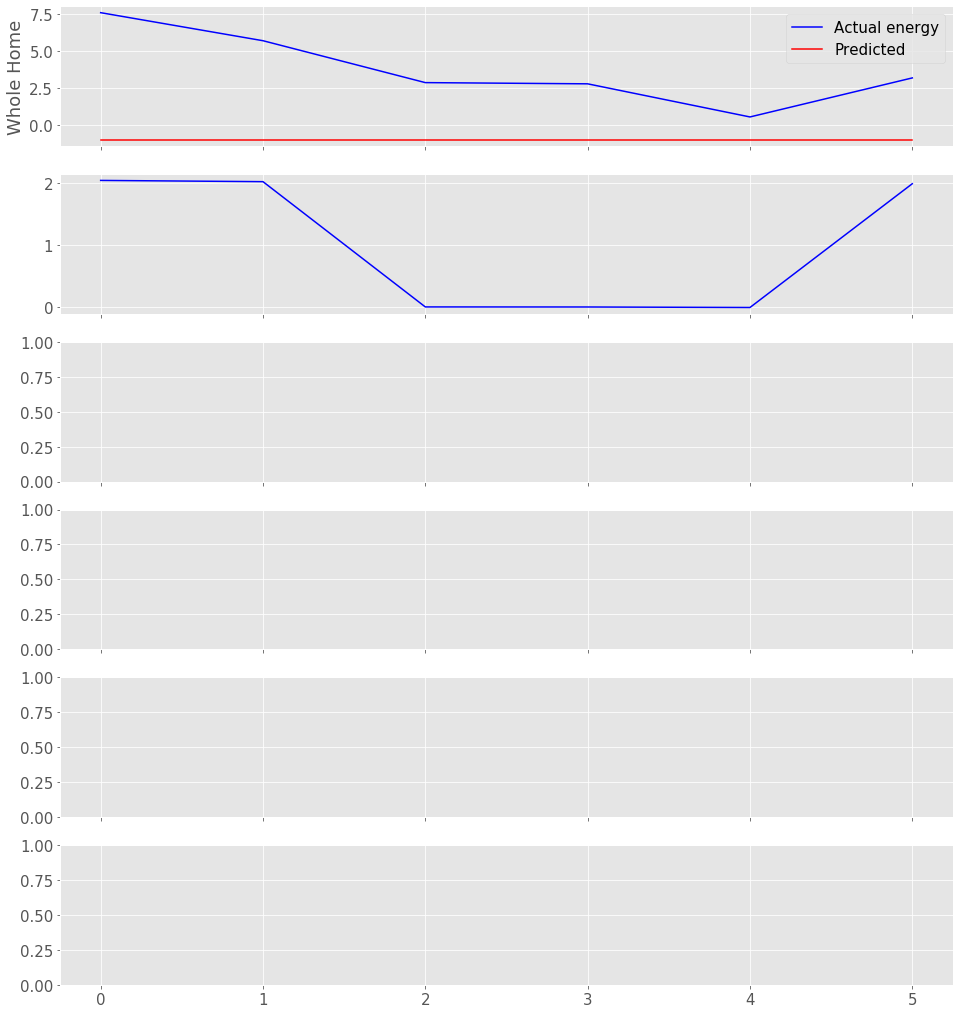

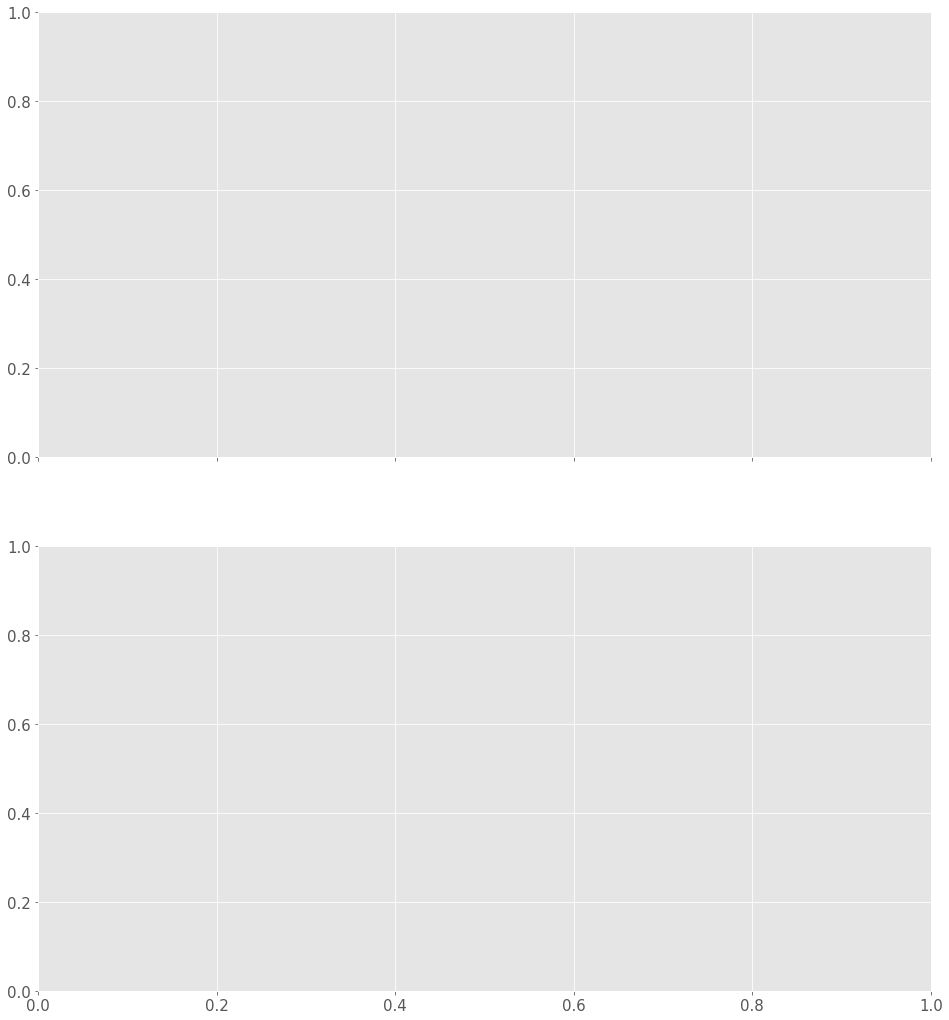

In [67]:
## row and column sharing
f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex='col', sharey='row', figsize=(16,18))
## piechart
f2, ((axes1, axes2)) = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(16,18))
pie_chart_true = []
pie_chart_pred = []

x = range(x_train[list(x_train.keys())[0]].shape[0])
plt.rcParams.update({'font.size': 15})

y = np.asarray(x_test_use)[0:,0]
ax1.plot(x, y, color='b',label='Actual energy')
y=[-1]*x_train[list(x_train.keys())[0]].shape[0]
ax1.plot(x, y, color='r', label='Predicted')
#ax1.set_ylim([0,2])
ax1.set_ylabel('Whole Home')
ax1.legend()
##
y = np.asarray(x_test[list(x_test.keys())[0]])[0:,0]
pie_chart_true.append(y.sum())
ax2.plot(x, y, color='b')
print(list(x_predict))